In [17]:
import org.jetbrains.kotlinx.dl.dataset.preprocessing.fileLoader

import org.jetbrains.kotlinx.dl.api.core.Functional
import org.jetbrains.kotlinx.dl.api.core.SavingFormat
import org.jetbrains.kotlinx.dl.api.core.WritingMode
import org.jetbrains.kotlinx.dl.api.core.activation.Activations
import org.jetbrains.kotlinx.dl.api.core.initializer.GlorotUniform
import org.jetbrains.kotlinx.dl.api.core.layer.Layer
import org.jetbrains.kotlinx.dl.api.core.layer.core.Dense
import org.jetbrains.kotlinx.dl.api.core.layer.freeze
import org.jetbrains.kotlinx.dl.api.core.loss.Losses
import org.jetbrains.kotlinx.dl.api.core.metric.Metrics
import org.jetbrains.kotlinx.dl.api.core.optimizer.Adam
import org.jetbrains.kotlinx.dl.api.core.shape.TensorShape
import org.jetbrains.kotlinx.dl.api.inference.TensorFlowInferenceModel
import org.jetbrains.kotlinx.dl.api.inference.keras.loadWeights
import org.jetbrains.kotlinx.dl.api.inference.keras.loadWeightsForFrozenLayers
import org.jetbrains.kotlinx.dl.api.inference.keras.saveModelConfiguration
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModelHub
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModels
import org.jetbrains.kotlinx.dl.api.inference.loaders.TFModels.CV.Companion.createPreprocessing
import org.jetbrains.kotlinx.dl.api.preprocessing.pipeline
import org.jetbrains.kotlinx.dl.dataset.OnHeapDataset
import org.jetbrains.kotlinx.dl.dataset.embedded.dogsCatsSmallDatasetPath
import org.jetbrains.kotlinx.dl.dataset.embedded.fashionMnist
import org.jetbrains.kotlinx.dl.dataset.generator.FromFolders
import org.jetbrains.kotlinx.dl.impl.inference.imagerecognition.predictLabel
import org.jetbrains.kotlinx.dl.impl.inference.imagerecognition.predictProbabilities
import org.jetbrains.kotlinx.dl.impl.preprocessing.call
import org.jetbrains.kotlinx.dl.impl.preprocessing.image.*
import org.jetbrains.kotlinx.dl.impl.summary.logSummary
import java.awt.image.BufferedImage
import java.io.File
import javax.imageio.ImageIO

val EPOCHS = 3
val TRAINING_BATCH_SIZE = 8
val TEST_BATCH_SIZE = 16
val NUM_CLASSES = 2
val TRAIN_TEST_SPLIT_RATIO = 0.7

In [55]:
val originalModelHub = TFModelHub(cacheDirectory = File("cache/pretrainedModels"))
val originalModelType = TFModels.CV.MobileNetV2()
val originalModel = originalModelHub.loadModel(originalModelType)
val hdfFile = originalModelHub.loadWeights(originalModelType)

originalModel.apply {
    compile(
        optimizer = Adam(),
        loss = Losses.MAE,
        metric = Metrics.ACCURACY
    )

    loadWeights(hdfFile)
    logSummary()
}

GraphTrainableModel(numberOfLayers=157) TrainableModel(numberOfClasses=1000) org.jetbrains.kotlinx.dl.api.core.Functional@2878f138

,"corkscrew, bottle screw"
,comic book
,crane
,analog clock
,comic book

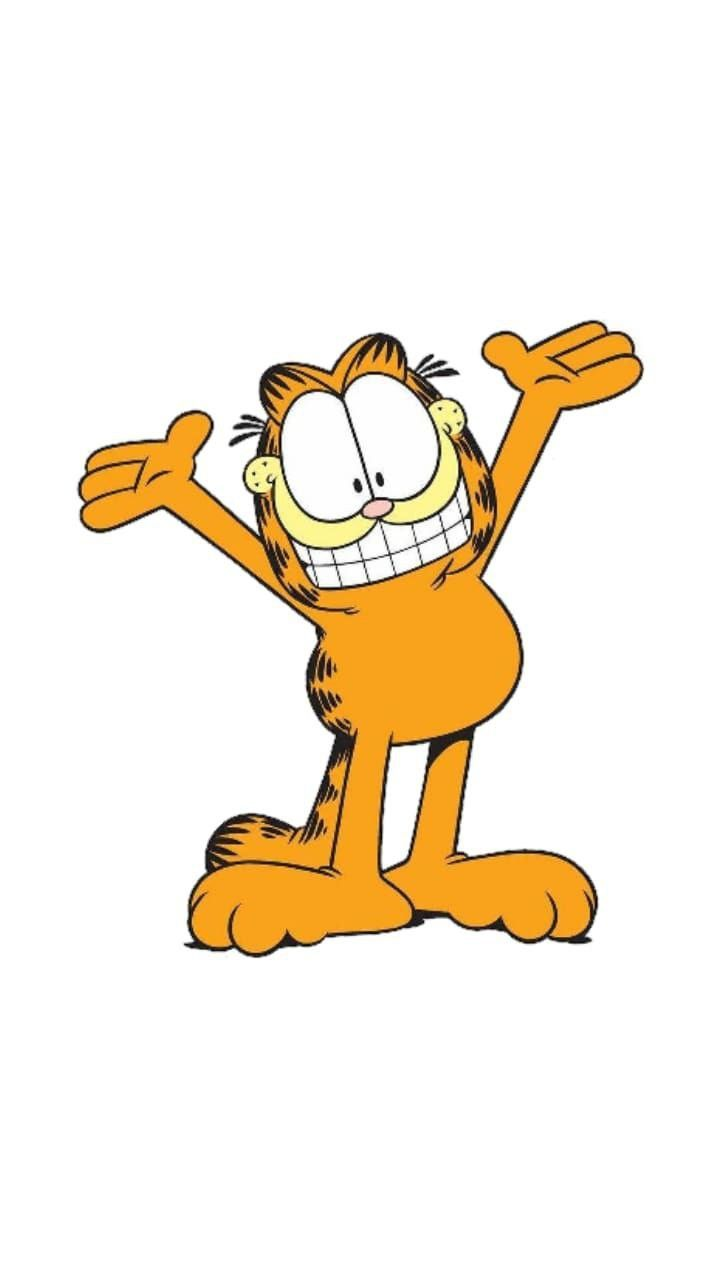
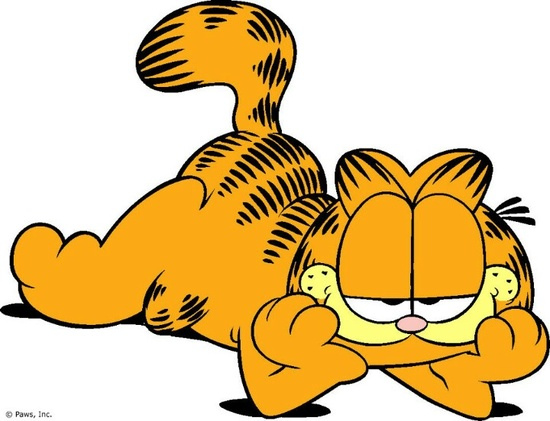
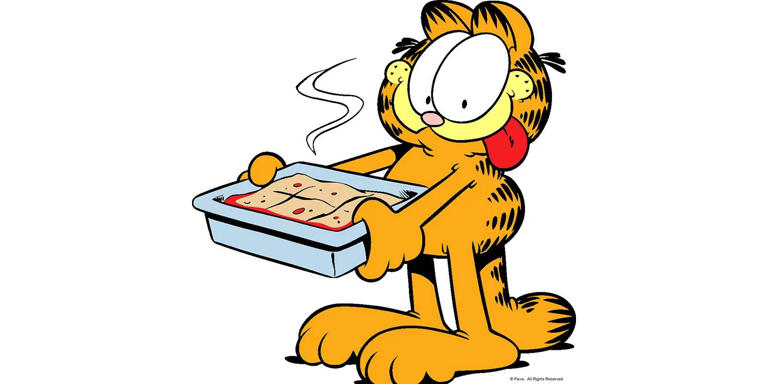
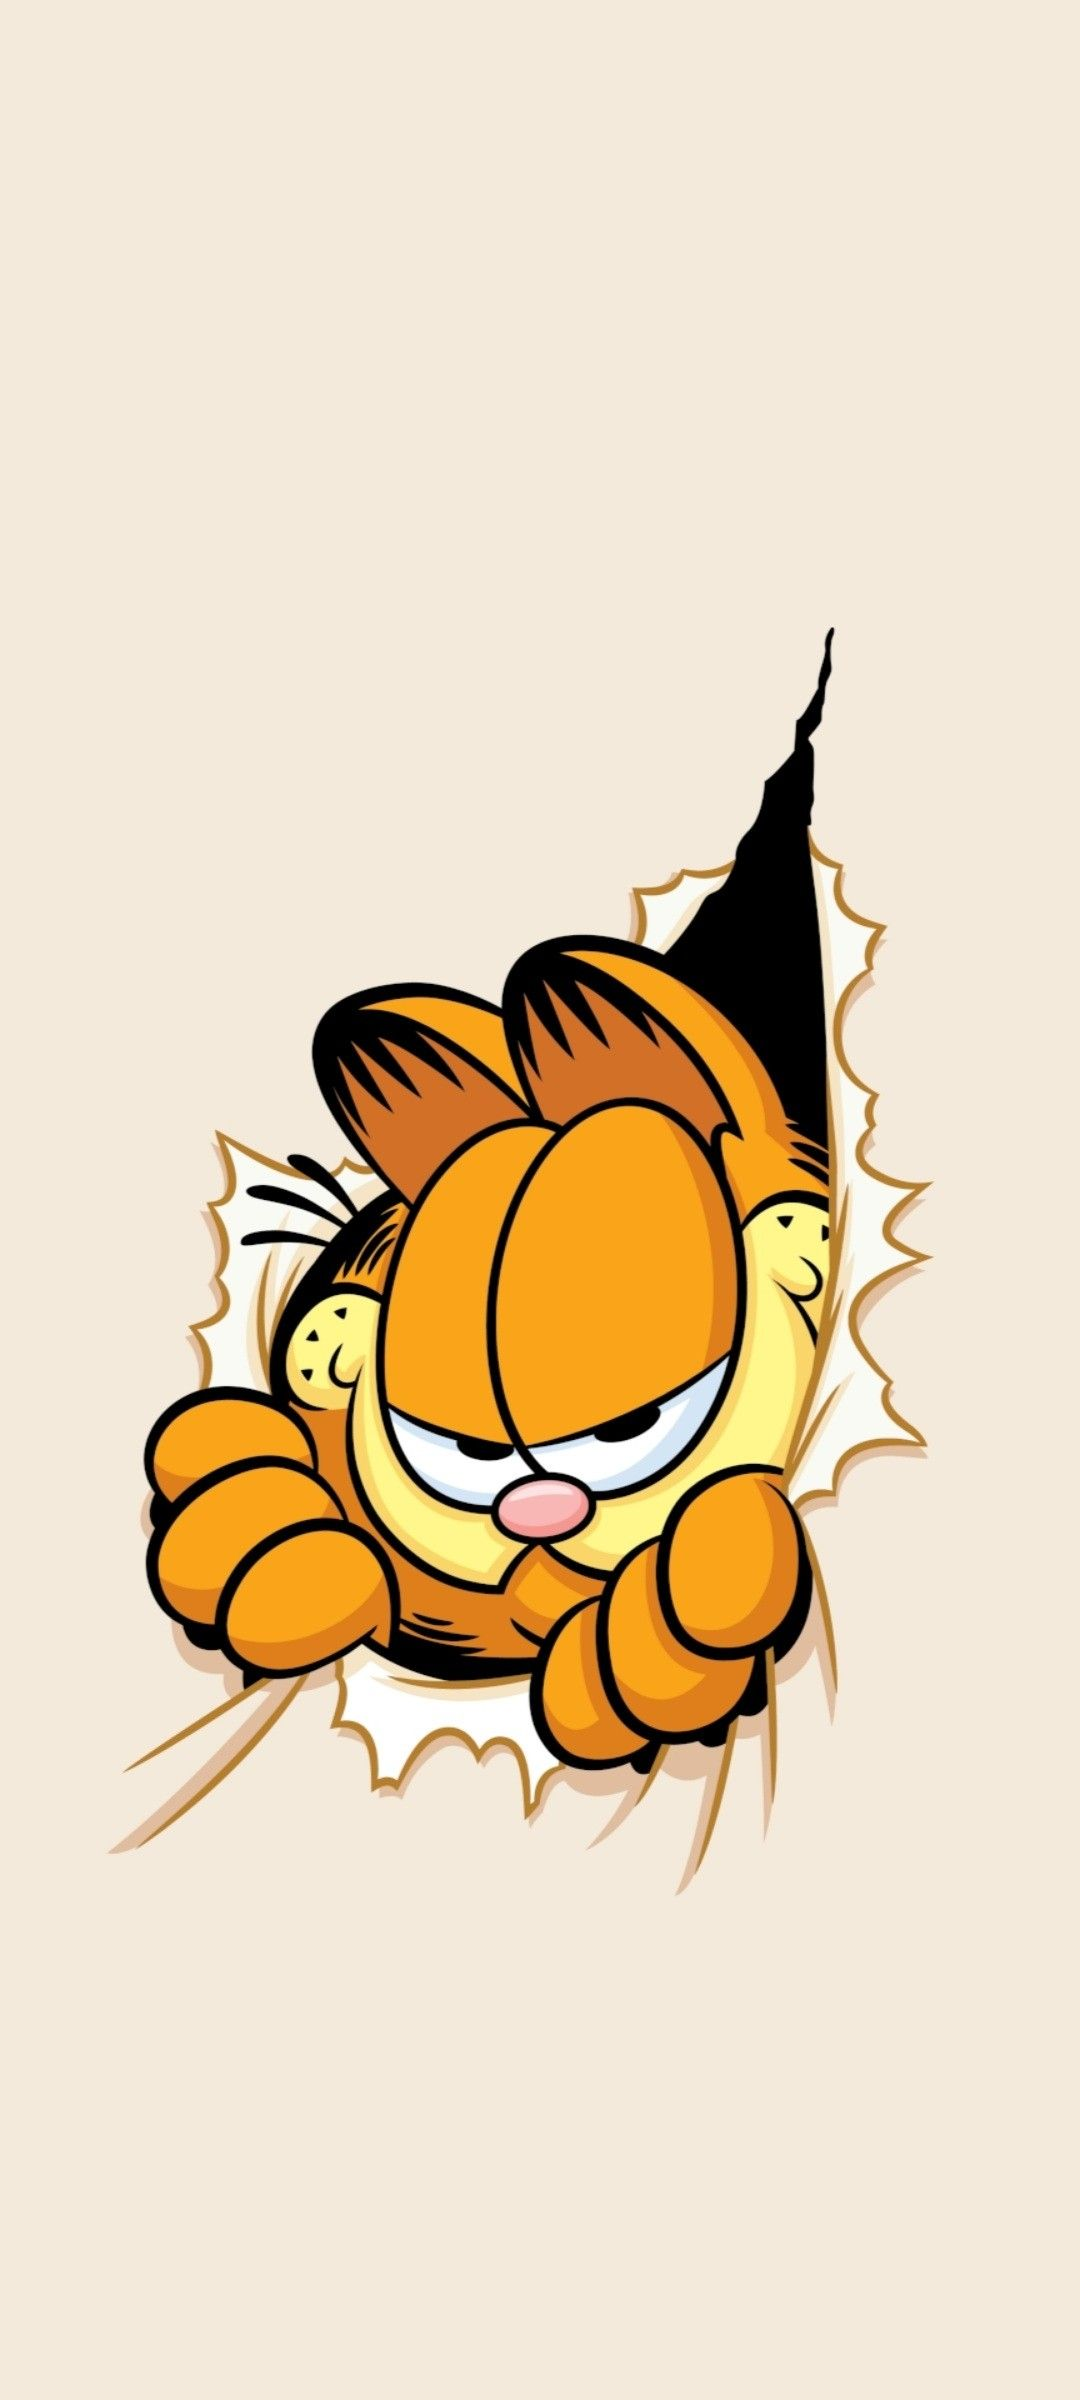
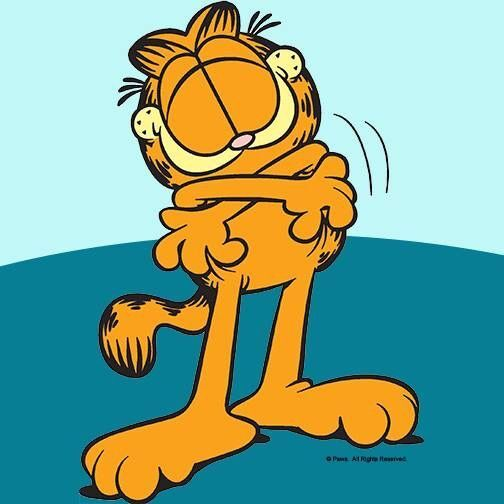

In [91]:
import java.nio.file.Files
import java.util.*

val labels = File("/Users/urs/development/github/ai/kotlindl/notebook/mobilenetv2-labels.txt").readLines().map { it.replace(Regex("""^[0-9\s]*"""), "") }.withIndex().associate { it.index to it.value }
fun encodeImageToBase64(imagePath: String): String {
    val file = File(imagePath)
    val bytes = Files.readAllBytes(file.toPath())
    return Base64.getEncoder().encodeToString(bytes)
}
val html = File(dogsCatsImages + "/garfield").listFiles().take(5).joinToString("") { imaFile ->
    val inputData = myFileDataLoader.load(imaFile)
    val res1 = originalModel.predictLabel(inputData)
    val res2 = originalModel.predictSoftly(inputData)
    """<tr><td><img src="data:image/jpeg;base64,${encodeImageToBase64(imaFile.absolutePath)}" width="100" height="100"/></td><td><b>${labels[res1]}</b></td></tr>"""
//    println("Predicted value for ${imaFile.name} is ${res2[0] > res2[1]} ${res2[0]} vs ${res2[1]} with label ${res1} being ${labels[res1]}")
}
HTML("<table>$html</table>")

In [28]:
import com.android.aaptcompiler.android.isTruthy

val modelHub = TFModelHub(cacheDirectory = File("cache/pretrainedModels"))
val modelType = TFModels.CV.MobileNetV2()
val model = modelHub.loadModel(modelType)

val hdfFile = modelHub.loadWeights(modelType)

model.use {
    it.compile(
        optimizer = Adam(),
        loss = Losses.MAE,
        metric = Metrics.ACCURACY
    )

    it.logSummary()
}

val layers = model.layers.toMutableList()
layers.forEach(Layer::freeze)

val lastLayer = layers.last()
for (outboundLayer in lastLayer.inboundLayers)
    outboundLayer.outboundLayers.remove(lastLayer)

layers.removeLast()

var x = Dense(
    name = "top_dense",
    kernelInitializer = GlorotUniform(),
    biasInitializer = GlorotUniform(),
    outputSize = 200,
    activation = Activations.Relu
)(layers.last())

x = Dense(
    name = "pred",
    kernelInitializer = GlorotUniform(),
    biasInitializer = GlorotUniform(),
    outputSize = 2,
    activation = Activations.Linear,
)(x)

val model2 = Functional.fromOutput(x)

val dogsCatsImages = "/Users/urs/development/github/ai/kotlindl/notebook/cache/datasets/small-dogs-vs-cats"//dogsCatsSmallDatasetPath() 
println(dogsCatsImages)

val dataset = OnHeapDataset.create(
    File(dogsCatsImages),
    //FromFolders(mapping = mapOf("cat" to 1)),
    FromFolders(mapping = mapOf("cat" to 0, "garfield" to 1)),
    modelType.createPreprocessing(model2)
).shuffle()
val (train, test) = dataset.split(TRAIN_TEST_SPLIT_RATIO)

model2.use {
    it.compile(
        optimizer = Adam(),
        loss = Losses.SOFT_MAX_CROSS_ENTROPY_WITH_LOGITS,
        metric = Metrics.ACCURACY
    )

    it.logSummary()

    it.loadWeightsForFrozenLayers(hdfFile)
    val accuracyBeforeTraining = it.evaluate(dataset = test, batchSize = TEST_BATCH_SIZE).metrics[Metrics.ACCURACY]
    println("Accuracy before training $accuracyBeforeTraining")

    it.fit(
        dataset = train,
        batchSize = TRAINING_BATCH_SIZE,
        epochs = EPOCHS
    )

    val accuracyAfterTraining = it.evaluate(dataset = test, batchSize = TEST_BATCH_SIZE).metrics[Metrics.ACCURACY]

    println("Accuracy after training $accuracyAfterTraining")


    val model2Dir = File("my-models/mobilenet_with_additional_training")
    it.save(
        model2Dir,
        saveOptimizerState = false,
        savingFormat = SavingFormat.JsonConfigCustomVariables(isKerasFullyCompatible = true),//SavingFormat.JsonConfigCustomVariables(),
        writingMode = WritingMode.OVERRIDE
    )
    //it.saveModel("my-models/mobilenet_with_additional_training_keras/model.h5", true)
}




/Users/urs/development/github/ai/kotlindl/notebook/cache/datasets/small-dogs-vs-cats
Accuracy before training 0.3616071343421936
Accuracy after training 1.0


In [29]:
val model = Functional.loadModelConfiguration(File("my-models/mobilenet_with_additional_training/modelConfig.json"))

model.use {
    setUpModel(it)
//    File(dogsCatsImages + "/cat").listFiles().forEach { imaFile ->
//        val inputData = myFileDataLoader.load(imaFile)
//        val res1 = it.predictLabel(inputData)
//        val res2 = it.predictSoftly(inputData)
//        println("Predicted value for ${imaFile.name} is ${res2[0]} with label ${res1}")
//    }
    File(dogsCatsImages + "/garfield").listFiles().forEach { imaFile ->
        val inputData = myFileDataLoader.load(imaFile)
        val res1 = it.predictLabel(inputData)
        val res2 = it.predictSoftly(inputData)
        println("Predicted value for ${imaFile.name} is ${res2[0]} with label ${res1}")
    }
}

Predicted value for garfield.17.jpg is 504.4208 with label 1
Predicted value for garfield.9.jpg is 492.91577 with label 1
Predicted value for garfield.8.jpg is 461.5647 with label 1
Predicted value for garfield.16.jpg is 590.03613 with label 1
Predicted value for garfield.28.jpg is 398.3715 with label 1
Predicted value for garfield.14.jpg is 442.35437 with label 1
Predicted value for garfield.15.jpg is 466.55743 with label 1
Predicted value for garfield.29.jpg is 289.39297 with label 1
Predicted value for garfield.11.jpg is 369.1349 with label 1
Predicted value for garfield.39.jpg is 589.7099 with label 1
Predicted value for garfield.38.jpg is 436.06918 with label 1
Predicted value for garfield.10.jpg is 560.4336 with label 1
Predicted value for garfield.12.jpg is 421.7434 with label 1
Predicted value for garfield.13.jpg is 624.8809 with label 1
Predicted value for garfield.48.jpg is 427.6883 with label 1
Predicted value for garfield.49.jpg is 450.63303 with label 1
Predicted value for

In [30]:
val myFileDataLoader = pipeline<BufferedImage>()
    .resize {
        outputHeight = 224
        outputHeight = 224
        interpolation = InterpolationType.BILINEAR
    }.convert { colorMode = ColorMode.BGR }
    .toFloatArray {  }
    .call(TFModels.CV.MobileNetV2().preprocessor)
    .fileLoader()

fun setUpModel(it:Functional): Functional {
    it.compile(
        optimizer = Adam(),
        loss = Losses.MAE,
        metric = Metrics.ACCURACY
    )

    it.logSummary()
    it.loadWeights(File("my-models/mobilenet_with_additional_training"))
    //it.layers.forEach{println(it.name)}
    return it
    
    
}

In [36]:
val model = Functional.loadModelConfiguration(File("my-models/mobilenet_with_additional_training/modelConfig.json"))

val m = setUpModel(model)
//    File(dogsCatsImages + "/cat").listFiles().forEach { imaFile ->
//    


Predicted value for cat.1.jpg is true 553.5949 vs 516.8541 with label 0
Predicted value for apartment_0000.jpg is true 428.3351 vs 406.84784 with label 0
Predicted value for cat.43.jpg is true 462.8981 vs 419.25705 with label 0


,garfield
,garfield
,garfield
,garfield
,garfield

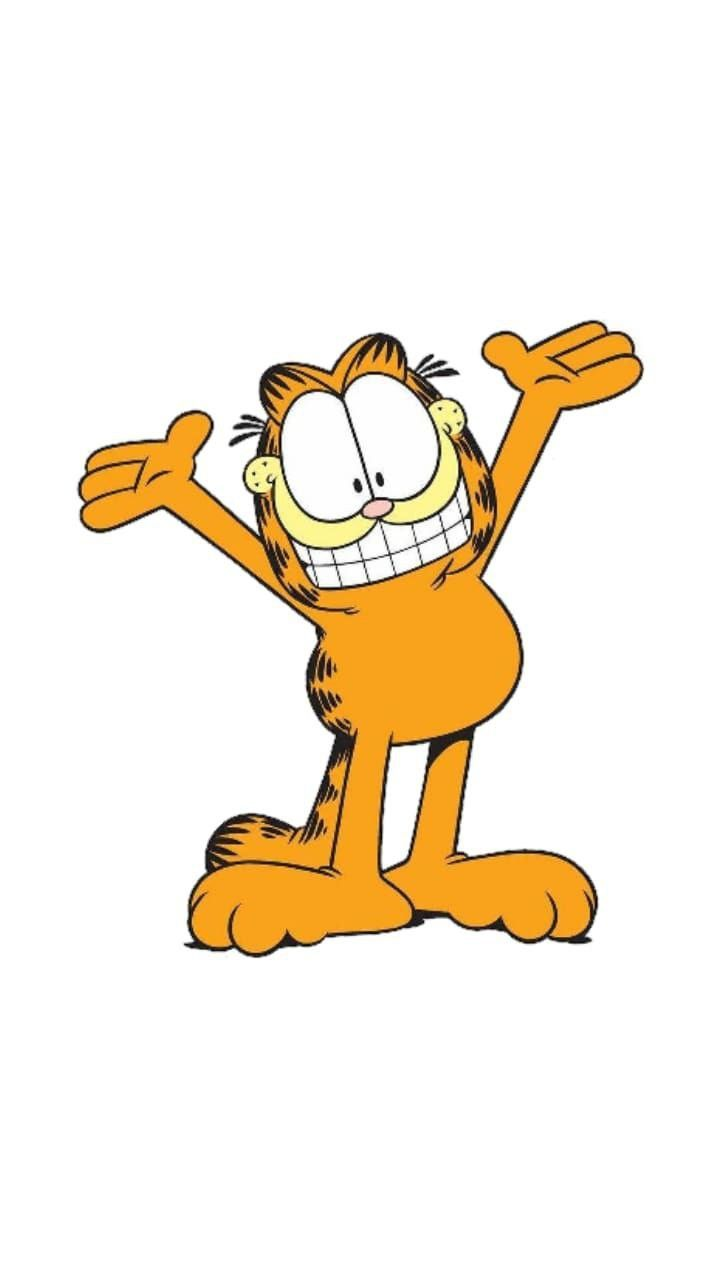
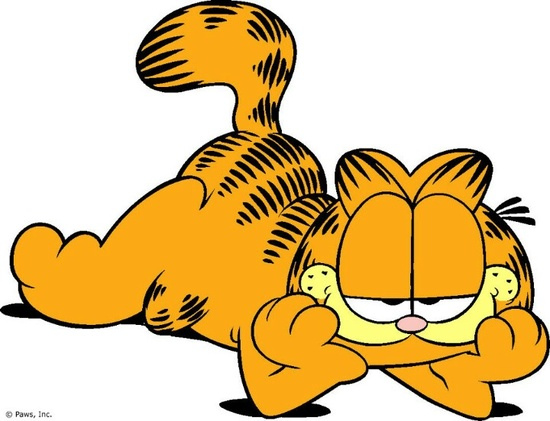
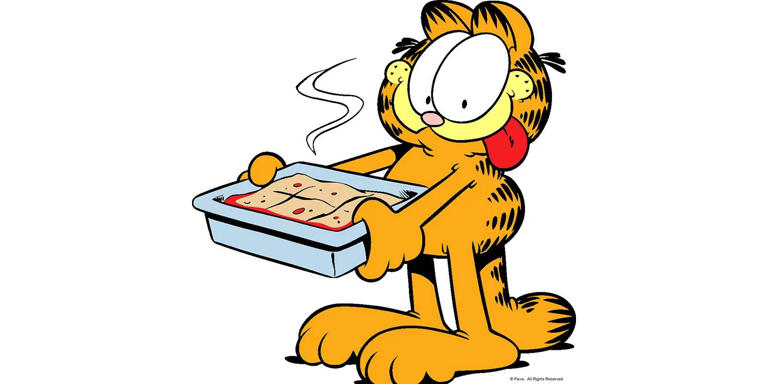
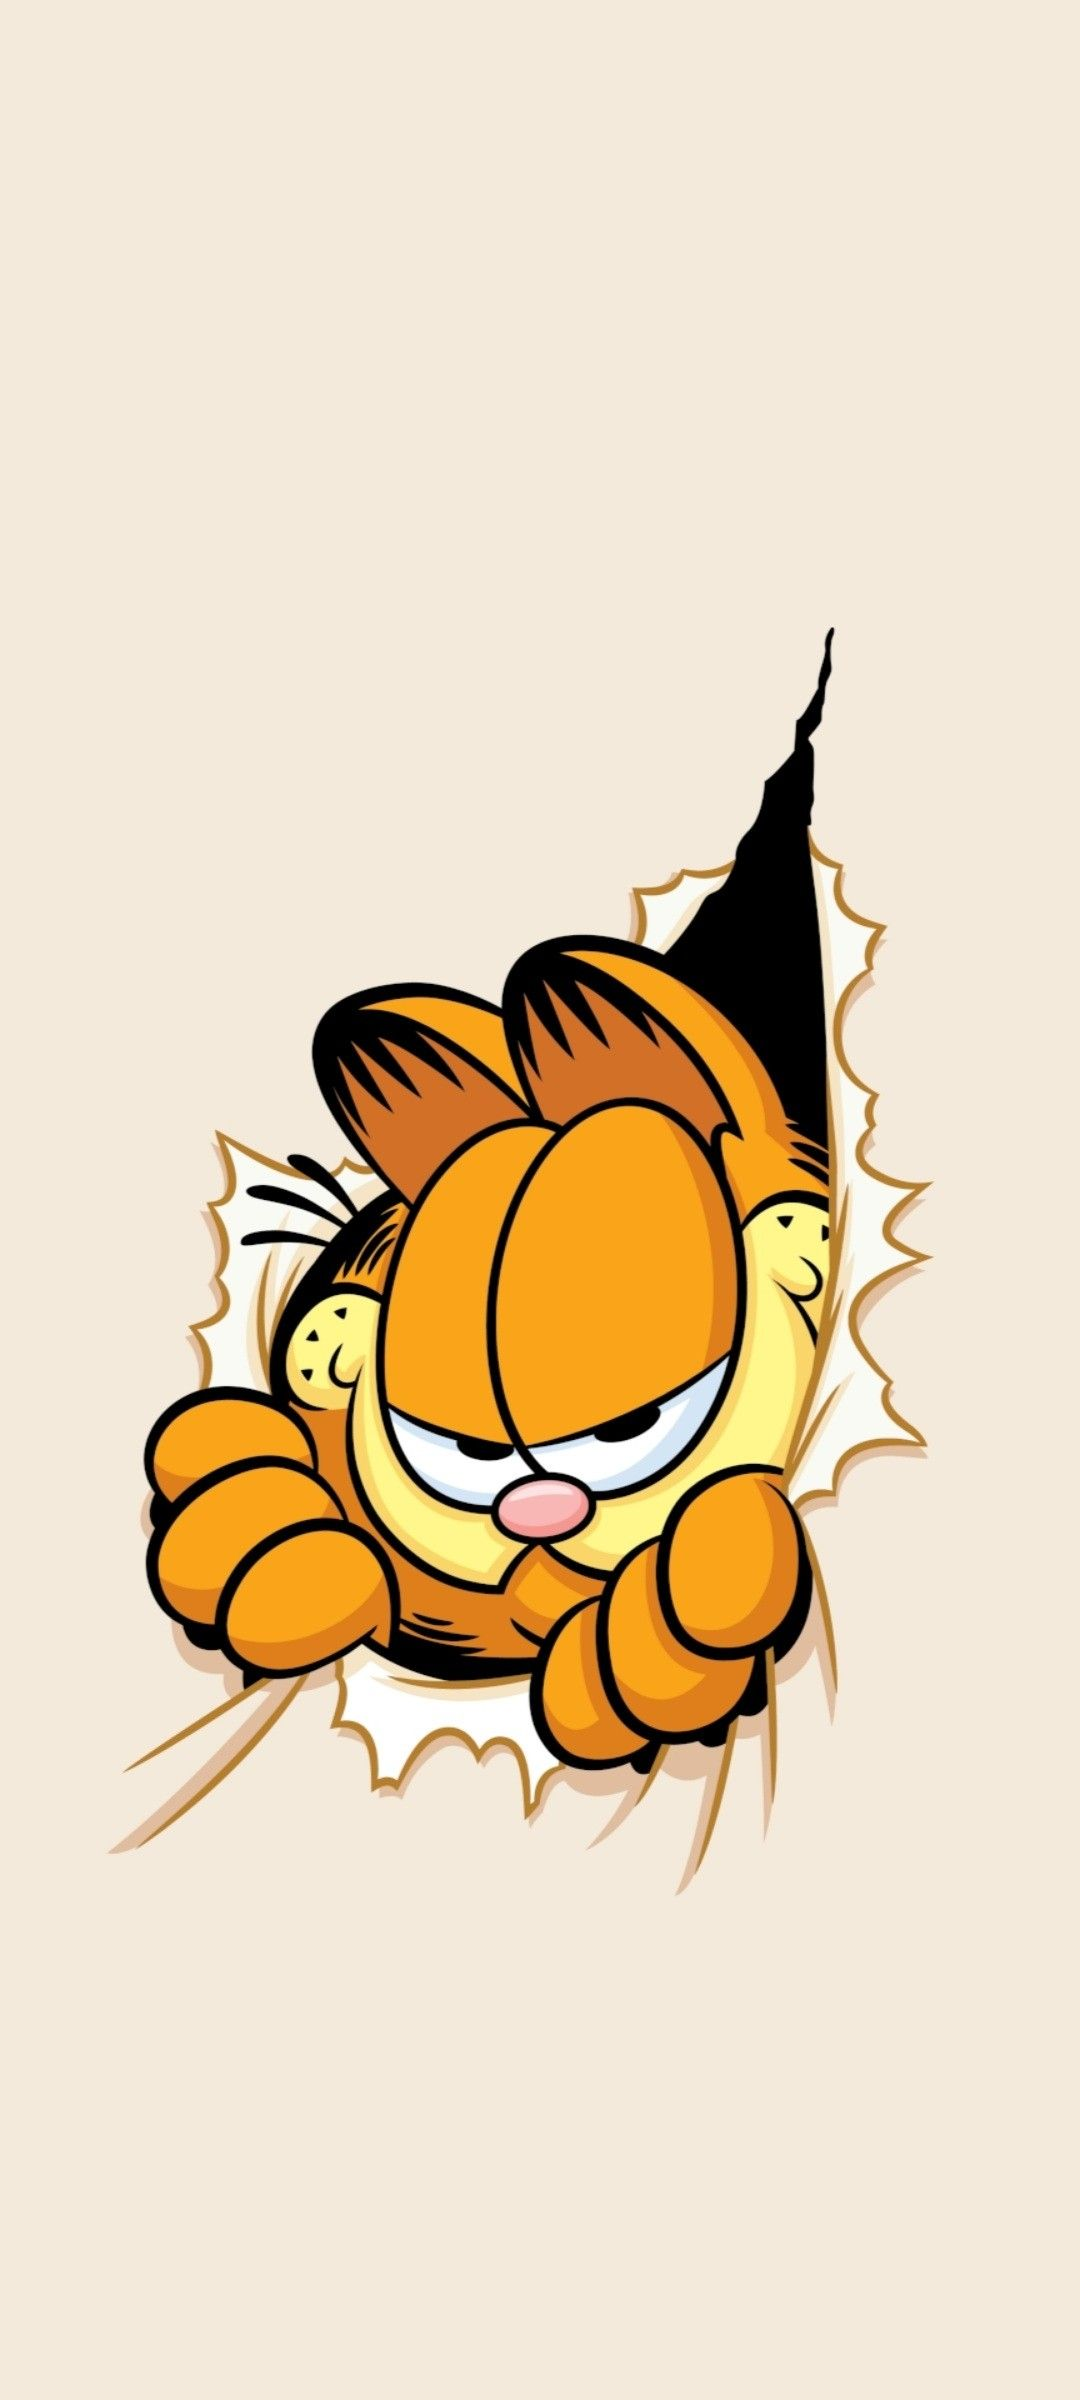
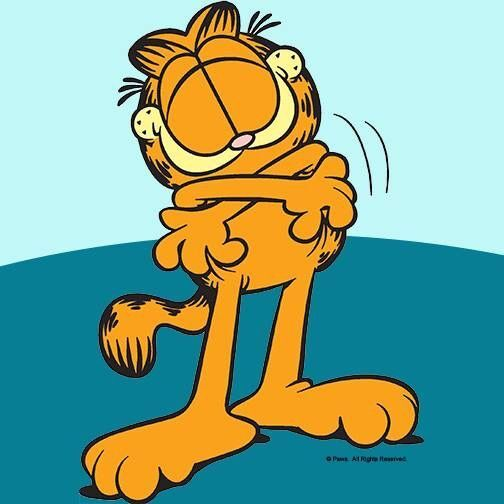

In [93]:
val newLabes = mapOf(0 to "other", 1 to "garfield")
File(dogsCatsImages + "/other").listFiles().forEach { imaFile ->
    val inputData = myFileDataLoader.load(imaFile)
    val res1 = m.predictLabel(inputData)
    val res2 = m.predictSoftly(inputData)
    println("Predicted value for ${imaFile.name} is ${res2[0] > res2[1]} ${res2[0]} vs ${res2[1]} with label ${res1}")
}

val html = File(dogsCatsImages + "/garfield").listFiles().take(5).joinToString("") { imaFile ->
    val inputData = myFileDataLoader.load(imaFile)
    val res1 = m.predictLabel(inputData)
    val res2 = m.predictSoftly(inputData)
    """<tr><td><img src="data:image/jpeg;base64,${encodeImageToBase64(imaFile.absolutePath)}" width="100" height="100"/></td><td><b>${newLabes[res1]}</b></td></tr>"""
//    println("Predicted value for ${imaFile.name} is ${res2[0] > res2[1]} ${res2[0]} vs ${res2[1]} with label ${res1} being ${labels[res1]}")
}
HTML("<table>$html</table>")